# Task 4 - Fire Evacuation Planning for the MI Building

In [444]:
%load_ext autoreload
%autoreload 2

from helpers.vae import VariationalAutoEncoder
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from helpers.data import get_fire_evac_dataset
from helpers.plots import plot_2d_train_test
from helpers.plots import plot_2d_fire_evac_set

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Loading the dataset and visualizing it

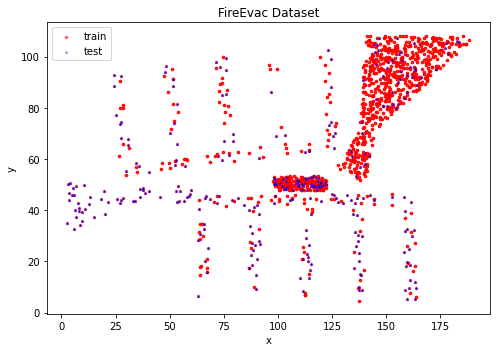

In [445]:
train, test = get_fire_evac_dataset()
plot_2d_train_test(
    train, test, xlabel="x", ylabel="y", title="FireEvac Dataset", save_path="plots/fire_evac_data.pdf", alpha=0.5
)

### 2. Training a VAE

In [446]:
# Data & model configuration
latent_dim = 2
batch_size = 32
hidden_size = 64
no_epochs = 200
verbosity = 1
num_channels = 1
input_shape = train[0].shape

Compared to Task 3, we reduce the batch_size because the train set is smaller

In [447]:
# preprocess data to be in range [0,1]
def normalise(data):
    max = data.max()
    min = data.min()

    data_normalised = (data - min) / (max - min)
    return data_normalised

def renormalise(data_normalised, data):
    max = data.max()
    min = data.min()
    data_renormalised = data_normalised * (max - min) + min
    return data_renormalised

train_normalised = normalise(train)
test_normalised = normalise(test)

Even though it is suggested to normalise the data to the interval [-1,1], we receive better results for interval [0,1]

In [448]:
vae = VariationalAutoEncoder(input_shape=input_shape, latent_dim=latent_dim, hidden_size=hidden_size)

Hyperparameters were tuned and the network was tested for:
- different dimensions of the latent space (2-32): latent_dim=2 returned best results
- different batch sizes (8-128), starting with a smaller batch size compared to Task 3 because the train set is smaller: batch_size=32 returned best results
- different hidden size (64-1024): hidden_size=64 returned best results
- different number of Dense layers (2-4): best results for 2 Dense layers
- different learning_rates (0.0001-0.001): best results for learning_rate=0.0005

In [449]:
# Compile VAE
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=50)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=opt)
# Train autoencoder
history = vae.fit(train_normalised, train_normalised, epochs=no_epochs, batch_size=batch_size, validation_data=(test_normalised, test_normalised), callbacks=[early_stopping])

Epoch 1/200
94/94 [==============================] - 1s 3ms/step - loss: 77.2053 - val_loss: 65.9913
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 30.5384 - val_loss: 44.5139
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 21.3014 - val_loss: 48.7413
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 19.5819 - val_loss: 40.1352
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 15.3357 - val_loss: 19.6722
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 7.4783 - val_loss: 11.3627
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 6.1379 - val_loss: 10.3638
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 5.8093 - val_loss: 9.8105
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 5.7329 - val_loss: 9.8899
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 5.5316 - val_loss: 10.2

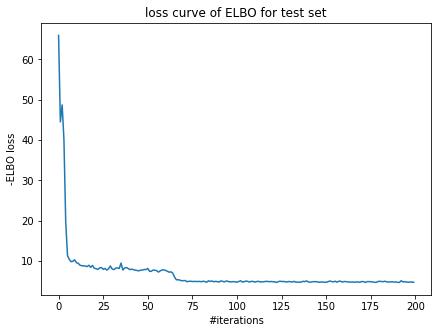

<Figure size 504x360 with 0 Axes>

In [450]:
# print loss history
loss_history = history.history['val_loss']

plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('-ELBO loss')
plt.show()
plt.savefig("plots/fire_evac_loss.pdf", bbox_inches="tight")

### 3. Plot of the reconstructed test set

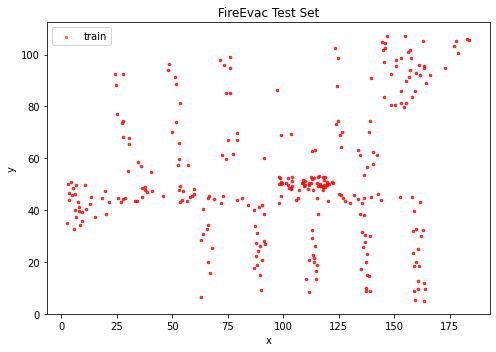

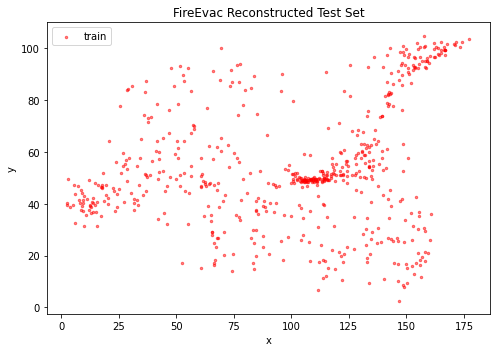

In [451]:
plot_2d_fire_evac_set(test, xlabel="x", ylabel="y", title="FireEvac Test Set", save_path="plots/fire_evac_test_data.pdf", alpha=0.5)

test_reconstructed = np.empty_like(test_normalised)
for i in range(test_normalised.shape[0]):
    _, _, z = vae.encoder(test_normalised[i-1].reshape(-1, 2))
    test_sample = vae.decoder(z)[0]
    test_reconstructed[i-1] = test_sample

test_reconstructed = renormalise(test_reconstructed, test)
plot_2d_fire_evac_set(test_reconstructed, xlabel="x", ylabel="y", title="FireEvac Reconstructed Test Set", save_path="plots/fire_evac_test_data_reconstruction.pdf", alpha=0.5)

### 4. Plot of generated samples

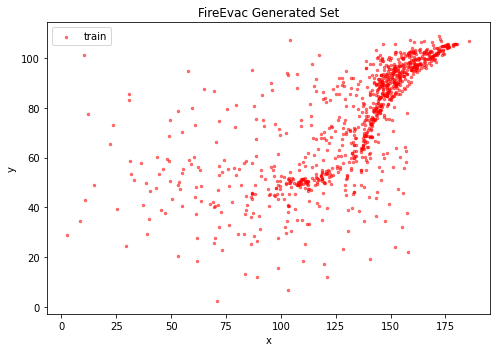

In [452]:
# TODO
# randomly choose input for decoder
# decode
# plot generated samples with plot fire evac set

def generate_samples(num_samples):
    """
    Visualises generation of num_samples digits

    Args:
        num_samples (int): number of samples to be generated

    Returns: array of sampled data
    """
    generated_samples = np.empty(shape=(num_samples, 2))
    for i in range(num_samples):
        z_sample = np.random.normal(size=latent_dim) 
        out = vae.decoder(np.array([z_sample]))[0]
        generated_samples[i] = out
    return renormalise(generated_samples, train)

generated_samples = generate_samples(1000)

plot_2d_fire_evac_set(generated_samples, xlabel="x", ylabel="y", title="FireEvac Generated Set", save_path="plots/fire_evac_test_data_generation.pdf", alpha=0.5)

### 5. Generate data to estimate the critical number of people for the MI building

In [457]:
def count_sensitive_area(samples):
    count = 0
    for sample in samples:
        x, y = sample
        if x > 130 and x < 150 and y > 50 and y < 70:
            count += 1
    return count

for i in range(950,1100):
    generated_samples = generate_samples(i)
    count = count_sensitive_area(generated_samples)
    if count > 95:
        print("For " + str(i) + " samples, there are " + str(count) + " people in the sensitive area")
    if count > 100:
        print("CRITICAL NUMBER IS REACHED")

For 962 samples, there are 96 people in the sensitive area
For 963 samples, there are 104 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 989 samples, there are 96 people in the sensitive area
For 993 samples, there are 98 people in the sensitive area
For 1005 samples, there are 111 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1010 samples, there are 107 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1027 samples, there are 103 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1033 samples, there are 102 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1036 samples, there are 103 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1040 samples, there are 100 people in the sensitive area
For 1042 samples, there are 102 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1043 samples, there are 106 people in the sensitive area
CRITICAL NUMBER IS REACHED
For 1053 samples, there are 96 people in the sensitive area

The critical number at the main entrance is reached for approximately 1000 samples (then there are more than 100 people in the area [130,150][50,70]). Approximately 10% of all people are located in the sensitive area. If this area should not allow more than 100 people for safety reasons, then a smaller number needs to be chosen because in some cases, the number is exceeded for 900-950 people in the MI building.

### Bonus:

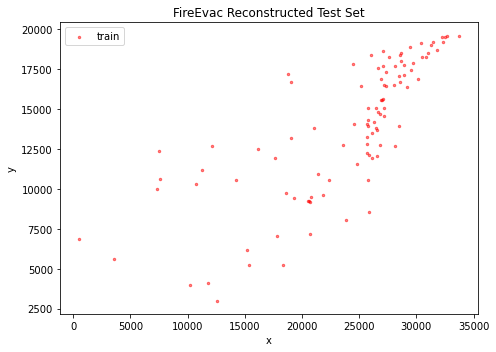

In [454]:
# generation of 100 people in the MI building
generated_positions = generate_samples(100)
generated_positions = renormalise(generated_positions, train)

plot_2d_fire_evac_set(generated_positions, xlabel="x", ylabel="y", title="FireEvac Reconstructed Test Set", save_path="plots/fire_evac_test_data_generation_bonus.pdf", alpha=0.5)